In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
#import tensorflow as tf
import keras
from keras.utils import multi_gpu_model
import tensorflow as tf
from temnn.knet import net
#from temdata.dataset import DataEntry,DataSet
from temnn.net.dataset import DataEntry,DataSet
from pyqstem.imaging import CTF
import matplotlib.pyplot as plt
# Peak detection
from stm.preprocess import normalize
from stm.feature.peaks import find_local_peaks, refine_peaks
from skimage.morphology import disk
from scipy.spatial import cKDTree as KDTree
import sys
import os
from collections import deque
from multiprocessing import Pool
import hyperspy.api as hs

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Data folders
data_dir = "data/cluster-110-single-class/"
#validation_dir = "data/cluster-110-single-class-test/"
validation_dir = data_dir  # A big no-no
graph_dir = 'graphs-110-negdefocus'
graph_path = os.path.join(graph_dir, 'clusters-54.h5')


In [3]:
def load(data_dir):
    "Load data folder."
    #models=sorted(glob(data_dir+"model/model_*.cfg"))
    waves=sorted(glob(data_dir+"wave/wave_*.npz"))
    #labels=sorted(glob(data_dir+"label/label_*.npy"))
    points=sorted(glob(data_dir+"points/points_*.npz"))
    #entries=[DataEntry(model,wave,label) for model,wave,label in zip(models,waves,labels)]
    entries = [DataEntry(wave=w, points=p) for w,p in zip(waves,points)]

    return DataSet(entries)

In [4]:
def load_CNN(graph_path, size, num_gpus=1):
    "Load the Keras neural net, and return a Model."
    kernel_num=32
    image_features=1
    num_classes=1

    if num_gpus == 1:
        x = keras.Input(shape=size+(image_features,))
        model = net.graph(x, output_features=num_classes)
        model.load_weights(graph_path)
    else:
        with tf.device('/cpu:0'):
            x = keras.Input(shape=size+(image_features,))
            model = net.graph(x, output_features=num_classes)
            model.load_weights(graph_path)
        model = multi_gpu_model(model, gpus=num_gpus)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
    return (x, model)

In [6]:
f = 'Au-CeO2_HVAC14_Hour_00_Minute_00_Second_00_Frame_0004.dm4'
a = hs.load(f)
image_size = a.data.shape
print(image_size)
# Must be divisible by 8
image_size = tuple(np.array(image_size) // 8 * 8)
print(image_size)
image = a.data[:image_size[0],:image_size[1]]
print(image.shape, image.dtype)

(1428, 1428)
(1424, 1424)
(1424, 1424) float32


In [7]:
# Find the latest CNN
print("Looking for CNNs in files matching", graph_path)
gr = graph_path
print("Using CNN parameters in", gr)
x, model = load_CNN(gr, image_size, 1)

Looking for CNNs in files matching graphs-110-negdefocus/clusters-54.h5
Using CNN parameters in graphs-110-negdefocus/clusters-54.h5


In [8]:
from temnn.net.mods import local_normalize

In [9]:
img2 = local_normalize(image, 120, 120)

In [10]:
img2.shape, img2.max(), img2.min()

((1424, 1424), 6.405968495260871, -4.624881518736737)

In [11]:
img2.shape = (1, ) + image_size + (1,)
predictions = model.predict(img2)

(-0.5, 1423.5, 1423.5, -0.5)

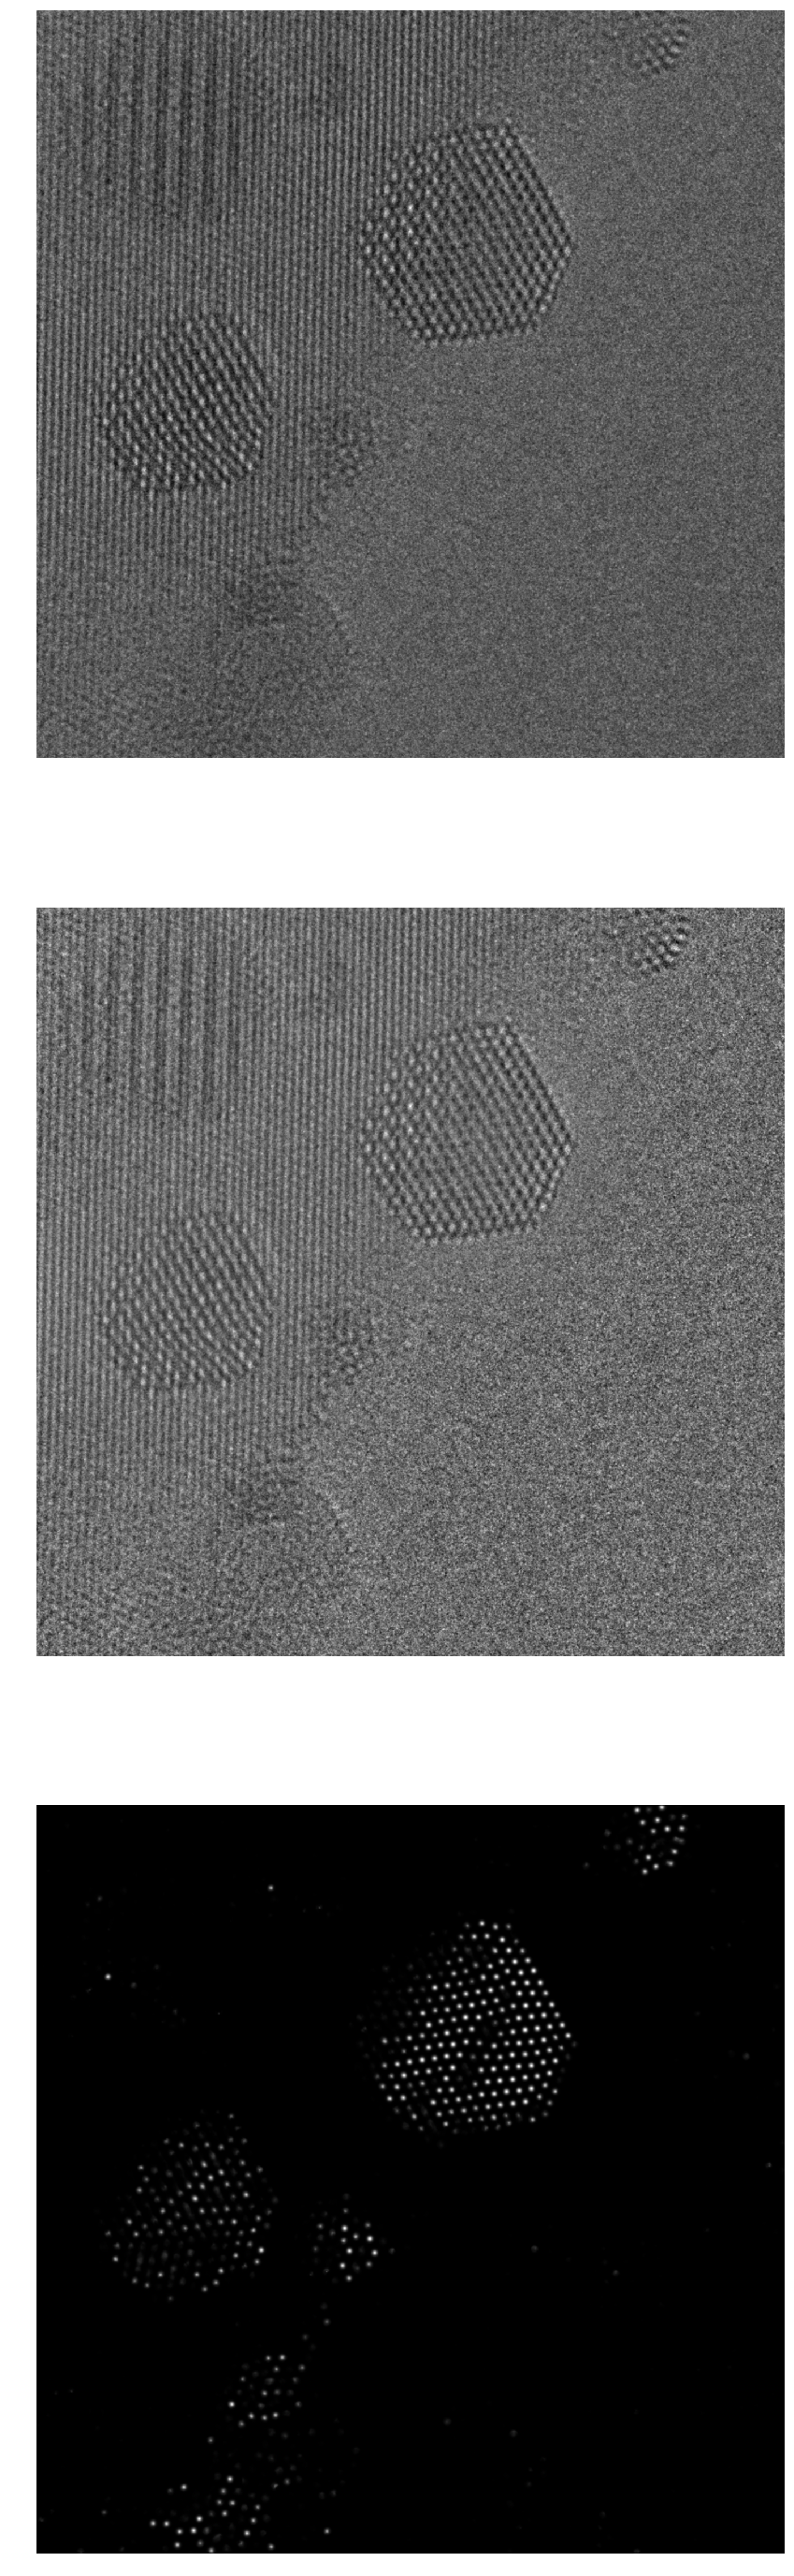

In [12]:
ig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,50))
im1 = ax1.imshow(image.T,cmap='gray')
im2 = ax2.imshow(img2[0,:,:,0].T,cmap='gray')
im3 = ax3.imshow(predictions[0,:,:,0].T,cmap='gray')                      
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')